In [1]:
import cv2
import math
import torch
import numpy as np
import sympy
from sympy import Line, Point
from matplotlib import pyplot as plt
from operator import itemgetter

In [2]:
with_log = False

In [3]:
def get_houth_line_v(lines):
    lines_v = []
    for line in lines:
        for rho,theta in line: 
            if theta < math.pi / 6 or theta > math.pi * 5 / 6:
                lines_v.append([(rho, theta)])
    return lines_v
            
def get_houth_line_h(lines):
    lines_h = []
    for line in lines:
        for rho,theta in line:
            if theta > math.pi * 2 / 6 and theta < math.pi * 4 / 6:
                lines_h.append([(rho, theta)]) 
    return lines_h

def L2(p):
    l2 = 0
    for i in p:
        l2 += i * i
    return math.sqrt(l2) 

def get_external_quad(points):
    min_x = 0
    min_y = 0
    max_x = 0
    max_y = 0
    for x, y in points:
        if (x > max_x):
            max_x = x
        if (y > max_y):
            max_y = y
        if (x < min_x):
            min_x = x
        if (y < min_y):
            min_y = y
    a = (min_x, min_y)  
    b = (max_x, min_y)
    c = (max_x, max_y)
    d = (min_x, max_y)
    return [a, b, c, d]

def get_np_array_from_points(points):
    arr = []
    for x, y in points:
        arr.append([x, y])
    return np.array(arr, dtype = "float32")

def reorder_points(points):
    c = np.array([0, 0], dtype = "float32")
    
    for x, y in points:
        c = c + np.array([x, y], dtype = "float32")
    dev = len(points)
    c = c / dev
    
    arr = []
    for x, y in points:
        vect = np.array([x, y]) - np.array([c[0], c[1]])
        arr.append(((x, y), math.atan2(vect[0], vect[1])))
    arr = sorted(arr, key=itemgetter(1))
    
    new_points = []
    for p, score in arr:
        new_points.append(p)
        
    return new_points

def Hough2Segm(line, wing = 256):
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + wing*(-b))
        y1 = int(y0 + wing*(a))
        x2 = int(x0 - wing*(-b))
        y2 = int(y0 - wing*(a))
        l = [(x1,y1), (x2, y2)]
    return l

def Hough2CVLine(line, wing = 256):
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + wing*(-b))
        y1 = int(y0 + wing*(a))
        x2 = int(x0 - wing*(-b))
        y2 = int(y0 - wing*(a))
        l = Line(Point(x1,y1), Point(x2, y2))
        return l

def draw_Hough_lines(lines, img, col, w = 2):
    wing = 256
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + wing*(-b))
            y1 = int(y0 + wing*(a))
            x2 = int(x0 - wing*(-b))
            y2 = int(y0 - wing*(a))
            cv2.line(img,(x1,y1),(x2,y2), col,w)

In [4]:
def rescale_map(img):
    h = img.shape[0]
    w = img.shape[1]
    map_img = cv2.GaussianBlur(img,(5, 5), 0)
    map_img = cv2.normalize(map_img,  None, 0, 255, cv2.NORM_MINMAX)
        
    img_hsv=cv2.cvtColor(map_img, cv2.COLOR_RGB2HSV)

    # lower mask (0-10)
    lower_red = np.array([0,64,64])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,64,64])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)
    
    red_mask = mask1 + mask0
    kernel3 = np.ones((3,3),np.uint8)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel3)
    kernel5 = np.ones((5,5),np.uint8)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel5)
    
    connectivity = 4  
    # Perform the operation
    output = cv2.connectedComponentsWithStats(red_mask, connectivity, cv2.CV_32S)
    num_labels = output[0]
    stats = output[2]
    centroids = output[3]
    
    scors = []
    comps = []
    for i in range(num_labels):
        centroid = centroids[i]
        if centroid[0] > h * 0.1 and centroid[1] > w * 0.1 and centroid[0] < h * 0.9 and centroid[1] < w * 0.9:
            stat = stats[i]
            if stat[2] < 0.1 * h and stat[3] < 0.1 * w:
                scors.append(stat[2] / stat[3])
                comps.append(stat)
    score = 1
    if len(scors) > 0:
        score = np.mean(scors);
    print(comps)
    print(score)
    
    newimg = cv2.resize(img,(int(w),int(h * score)))
    return newimg

In [5]:
def get_quad(img): 
    tmp = img.copy()
    w, h = img.shape
    quad = [(0, 0), (h, 0),(h, w), (0, w)]
    
    center = (int(w/2), int(h/2))
    #
    zone = img[:center[0],:]
    if (with_log):
        plt.figure()
        plt.imshow(zone)
    
    lines = []
    lines = cv2.HoughLines(zone , 1, np.pi/360, int(h / 3))
    if lines is None:
        return quad
    lines = get_houth_line_h(lines)
    if len(lines) == 0:
        return quad
    line0 = Hough2CVLine(lines[0])
    #                      
    zone = img[center[0]:,]
    if (with_log):
        plt.figure()
        plt.imshow(zone)
    
    lines = []
    lines = cv2.HoughLines(zone , 1, np.pi/360, int(h / 3))
    if lines is None:
        return quad
    lines = get_houth_line_h(lines)
    if len(lines) == 0:
        return quad
    line2 = Hough2CVLine(lines[0])
    p1 = Point(0, center[0]) + line2.p1
    p2 = Point(0, center[0]) + line2.p2
    line2 = Line(p1, p2)
    #
    zone = img[:,:center[1]]
    if (with_log):
        plt.figure()
        plt.imshow(zone)
    
    lines = []
    lines = cv2.HoughLines(zone , 1, np.pi/360, int(w / 3))
    if lines is None:
        return quad
    lines = get_houth_line_v(lines)
    if len(lines) == 0:
        return quad
    line1 = Hough2CVLine(lines[0])
    #
    zone = img[:,center[1]:]
    if (with_log):
        plt.figure()
        plt.imshow(zone)
    
    lines = []
    lines = cv2.HoughLines(zone , 1, np.pi/360, int(w / 3))
    if lines is None:
        return quad
    lines = get_houth_line_v(lines)
    if len(lines) == 0:
        return quad
    line3 = Hough2CVLine(lines[0])
    p1 = Point(center[1], 0) + line3.p1
    p2 = Point(center[1], 0) + line3.p2
    line3 = Line(p1, p2)
    
    #                        
    a = line0.intersection(line1) 
    if  not a or not isinstance(a[0], Point):
        return quad
                    
    b = line1.intersection(line2)
    if  not b or not isinstance(b[0], Point):
        return quad
                   
    c = line2.intersection(line3)
    if  not c or not isinstance(c[0], Point):
        return quad
                    
    d = line3.intersection(line0)
    if  not d or not isinstance(d[0], Point):
        return quad
    
    quad = [(a[0].x, a[0].y), (b[0].x, b[0].y), (c[0].x, c[0].y), (d[0].x, d[0].y)]
    
    return quad

In [26]:
def get_map_zone(img):
    tmp = img.copy()
    
    diag = np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2)
    n = int(diag / 100) * 2 + 1
    shape = img.shape

    edges = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    edges = cv2.GaussianBlur(edges,(5, 5), 0)
    if (with_log):
        plt.figure()
        plt.imshow(edges)

    edges = cv2.normalize(edges,  edges, 0, 255, cv2.NORM_MINMAX)
    if (with_log):
        plt.figure()
        plt.imshow(edges)

    edges = cv2.Laplacian(edges,cv2.CV_8UC1)
    if (with_log):
        plt.figure()
        plt.imshow(edges)
    
    edges = cv2.adaptiveThreshold(edges,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,n,-4)
    if (with_log):
        plt.figure()
        plt.imshow(edges)

    quad = get_quad(edges)
    
    quad = reorder_points(quad)

    if (with_log):
        a = quad[0] 
        b = quad[1]
        cv2.line(tmp,a,b,(255,0,0),4)
        a = quad[2]
        b = quad[1]
        cv2.line(tmp,a,b,(255,0,0),4)
        a = quad[2]
        b = quad[3]
        cv2.line(tmp,a,b,(255,0,0),4)
        a = quad[0]
        b = quad[3]
        cv2.line(tmp,a,b,(255,0,0),4)
        
        plt.figure()
        plt.imshow(tmp)

    src_quad = get_np_array_from_points(quad)
    
    ab = [src_quad[1][0] - src_quad[0][0], src_quad[1][1] - src_quad[0][1]]
    bc = [src_quad[2][0] - src_quad[1][0], src_quad[2][1] - src_quad[1][1]]
    cd = [src_quad[3][0] - src_quad[2][0], src_quad[3][1] - src_quad[2][1]]
    da = [src_quad[0][0] - src_quad[3][0], src_quad[0][1] - src_quad[3][1]]
    new_h = int((L2(ab) + L2(cd)) * 0.5)
    new_w = int((L2(bc) + L2(da)) * 0.5)
       
    dst = [(0, 0), (0, new_h), (new_w, new_h), (new_w, 0)]
    dst = reorder_points(dst)
    dst_quad = get_np_array_from_points(dst)
       
    M = cv2.getPerspectiveTransform(src_quad, dst_quad)
    warped = cv2.warpPerspective(img, M, (new_w, new_h))
    
    return warped

[array([45, 69,  7, 15, 91], dtype=int32), array([45, 90,  7,  6, 37], dtype=int32), array([165,  99,   7,   7,  47], dtype=int32), array([ 45, 119,   7,   6,  38], dtype=int32), array([ 45, 157,   7,  15,  92], dtype=int32), array([ 45, 178,   7,   6,  38], dtype=int32), array([164, 178,   7,   6,  40], dtype=int32), array([124, 182,   6,   6,  34], dtype=int32), array([ 47, 216,   8,   3,  24], dtype=int32)]
1.1407407407407408


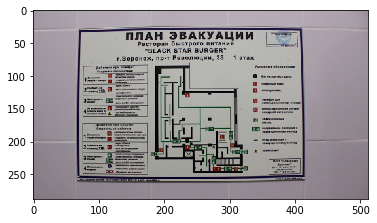

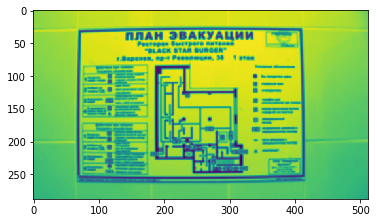

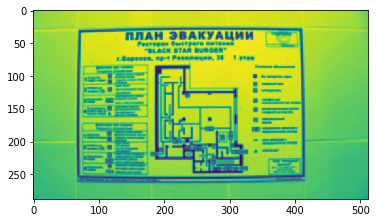

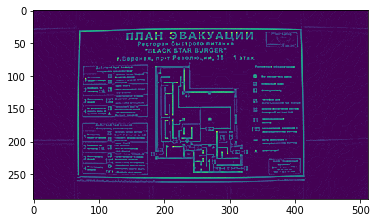

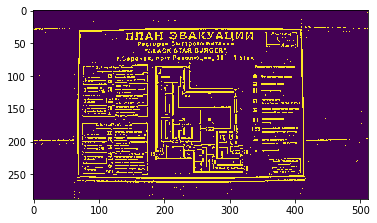

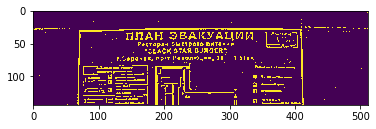

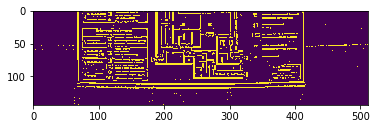

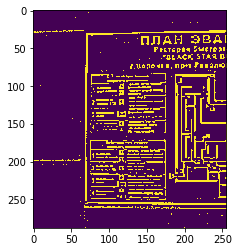

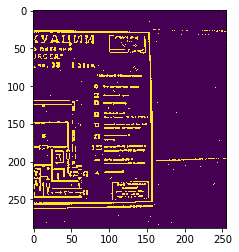

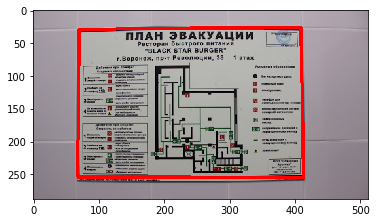

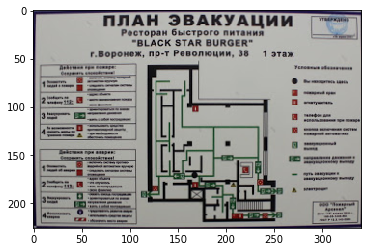

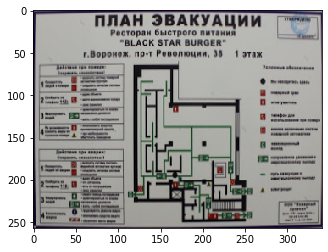

In [27]:
img = cv2.imread('photo/20.jpg')
img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)

warped = get_map_zone(img)
plt.figure()
plt.imshow(warped)

warped = rescale_map(warped)
plt.figure()
plt.imshow(warped)

In [28]:
def addPadding(img, padX, padY):    
    dst = cv2.copyMakeBorder(img, padY, padY, padX, padX, cv2.BORDER_CONSTANT, None, [255, 255, 255])

    return dst

In [29]:
def generateTransform(src_shape, anglex, angley, anglez, fov = math.pi / 2):
    w = src_shape[0]
    h = src_shape[1]
    
    
    l = np.sqrt(w ** 2 + h ** 2) / 2 / np.tan(fov / 2)
    
    rx = np.array([[1, 0, 0],
                   [0, np.cos(anglex), np.sin(anglex)],
                   [0, -np.sin(anglex), np.cos(anglex)]], np.float32)
 
    ry = np.array([[np.cos(angley), 0, -np.sin(angley)],
                   [0, 1, 0],
                   [np.sin(angley), 0, np.cos(angley)]], np.float32)
 
    rz = np.array([[np.cos(anglez), np.sin(anglez), 0],
                   [-np.sin(anglez), np.cos(anglez), 0],
                   [0, 0, 1]], np.float32)
 
    r = rx.dot(ry).dot(rz)
    
    src = []
    src.append([0, 0])
    src.append([w, 0])
    src.append([w, h])
    src.append([0, h])
       
    list_src = [[x - w / 2.0, y - h / 2.0, l] for x, y in src]
    
    list_dst = [list(r.dot(p)) for p in list_src]
    
    center = np.array([0.0, 0.0, l], np.float32)  
    center = list(r.dot(center))
    
    l = center[2]
    
    list_dst = [[x / z * l, y /z * l, z/z * l] for x, y, z in list_dst]
    
    list_dst = [list(np.array(p) - np.array(center) + np.array([w / 2.0, h / 2.0, 0])) for p in list_dst]
    
    dst = list(np.array(list_dst)[:, :-1])
    dst = [list(p) for p in dst]
 
    dst = [np.array(p) for p in dst]
    dst = np.array(dst, np.float32)
    
    src = [np.array(p) for p in src]
    src = np.array(src, np.float32)
    
    tr = cv2.getPerspectiveTransform(src, dst)
    return tr
    
def perspectiveTransform(img, tr):    
    dst = cv2.warpPerspective(img, tr, img.shape, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT, 255)
    return dst

[array([438, 244,  21,  21, 428], dtype=int32), array([288, 421,  20,  20, 393], dtype=int32), array([150, 581,  20,  21, 414], dtype=int32), array([149, 637,  21,  21, 417], dtype=int32), array([301, 638,  21,  22, 454], dtype=int32)]
0.9813852813852815


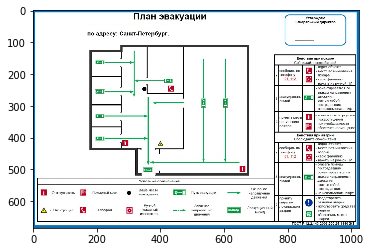

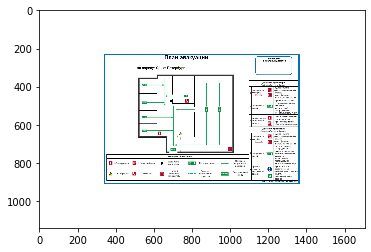

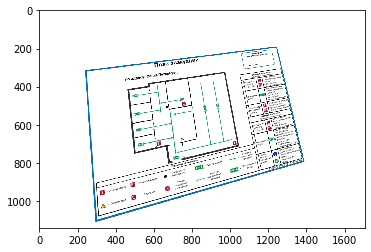

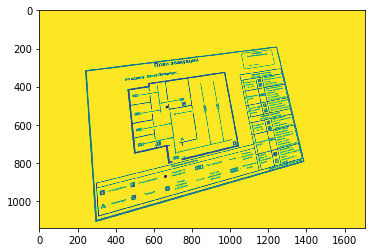

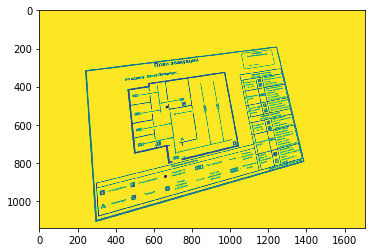

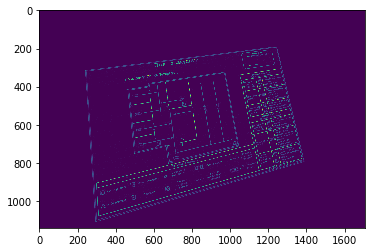

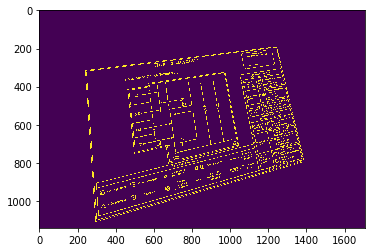

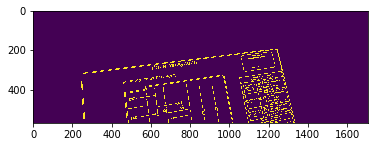

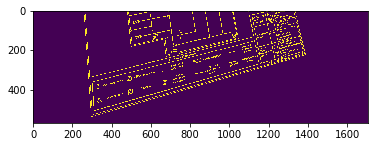

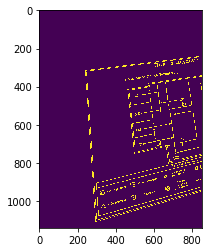

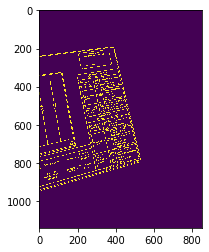

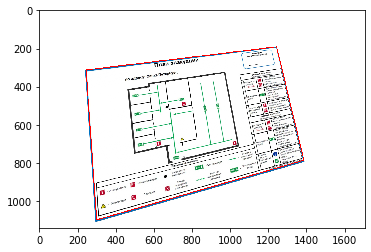

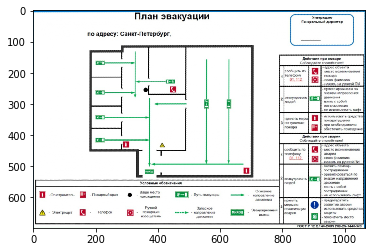

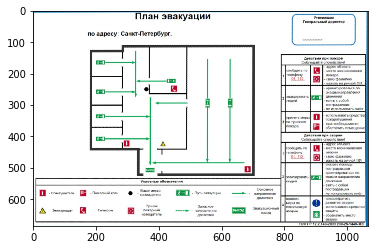

In [30]:
img = cv2.imread('IMG/12.PNG')
img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)

padX = int(img.shape[1] / 3)
padY = int(img.shape[0] / 3)
#углы поворота в радианах
rx, ry, rz = (0.2, 0.2, 0.2)

tmp = cv2.copyMakeBorder(img, padY, padY, padX, padX, cv2.BORDER_CONSTANT, value=(255, 255, 255))
plt.figure()
plt.imshow(tmp)

w = tmp.shape[0]
h = tmp.shape[1]
tr = generateTransform((h, w), rx, ry, rz)
tmp = cv2.warpPerspective(tmp, tr, (h, w), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
plt.figure()
plt.imshow(tmp)

warped = get_map_zone(tmp)
plt.figure()
plt.imshow(warped)

warped = rescale_map(warped)
plt.figure()
plt.imshow(warped)

In [71]:
def get_map(img):  
    map_img = cv2.GaussianBlur(img,(3, 3), 0)
    map_img = cv2.normalize(map_img,  None, 0, 255, cv2.NORM_MINMAX)
    if (with_log):
        plt.figure()
        plt.imshow(map_img)
        
    img_hsv = cv2.cvtColor(map_img, cv2.COLOR_RGB2HSV)
    img_map = cv2.cvtColor(map_img, cv2.COLOR_RGB2GRAY)
    img_map = cv2.bitwise_not(img_map)

    H, S, V = cv2.split(img_hsv)
    mask_gray1 = V < 255.0 - S * 6.0
    if (with_log):
        plt.figure()
        plt.imshow(mask_gray1)
    mask_gray2 = V < 128.0 - S / 4.0
    if (with_log):
        plt.figure()
        plt.imshow(mask_gray2)
    mask_gray = mask_gray1 + mask_gray2
    if (with_log):
        plt.figure()
        plt.imshow(mask_gray)
    
    img_map = mask_gray * img_map
    return img_map

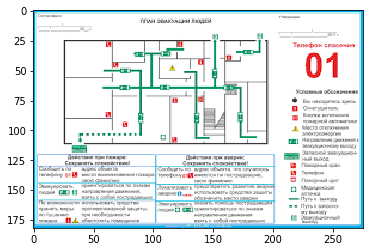

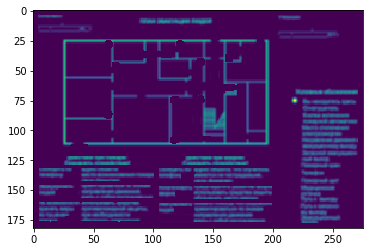

In [103]:
img = cv2.imread('IMG/9.PNG')
img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)
img_map = get_map(img)
plt.figure()
plt.imshow(img_map)

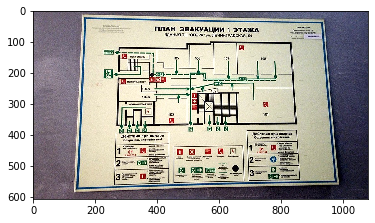

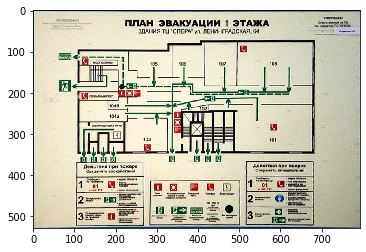

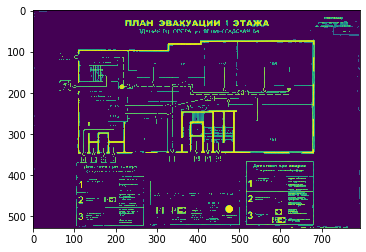

In [94]:
with_log = False
img = cv2.imread('photo/29.jpg')
img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)

warped = get_map_zone(img)
plt.figure()
plt.imshow(warped)

img_map = get_map(warped)
plt.figure()
plt.imshow(img_map)